In [15]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from baseline.splits import split_data
from baseline.data import MoleculeDatapoint, MoleculeDataset
from baseline.utils import make_rdkit_mol, get_fingerprint
from baseline.models import FeedForwardNetwork, train_one_epoch, evaluate

In [2]:
path = "/home/hwpang/Projects/BaselineML/data/biogen_solubility.csv"
data_df = pd.read_csv(path)

In [3]:
data_df["mol"] = data_df["SMILES"].apply(make_rdkit_mol)

In [4]:
datapoints = [
    MoleculeDatapoint(
        mol,
        solubility,
        featurizer=lambda x: get_fingerprint(x, method="morgan", count_based=True),
    )
    for mol, solubility in zip(data_df["mol"], data_df["logS"])
]

In [5]:
train_dpoints, val_dpoints, test_dpoints = split_data(datapoints)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [24]:
train_dset = MoleculeDataset(train_dpoints)
val_dset = MoleculeDataset(val_dpoints)
test_dset = MoleculeDataset(test_dpoints)

feature_scaler = train_dset.normalize_features()
val_dset.normalize_features(feature_scaler)
test_dset.normalize_features(feature_scaler)

label_scaler = train_dset.normalize_labels()
val_dset.normalize_labels(label_scaler)
# test_dset.normalize_labels(label_scaler)

train_dset.to(device)
val_dset.to(device)
test_dset.to(device)

In [25]:
train_dataloader = torch.utils.data.DataLoader(train_dset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(val_dset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dset, shuffle=False)

In [9]:
model = FeedForwardNetwork(
    input_size=2048,
    hidden_size=512,
    output_size=1,
    n_layers=3,
    dropout=0.1,
    activation="ReLU",
).to(device)
print(model)

FeedForwardNetwork(
  (activation): ReLU()
  (sequences): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [10]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_one_epoch(train_dataloader, model, loss_function, optimizer)

    train_loss = evaluate(train_dataloader, model, loss_function)
    print(f"Training Loss: {train_loss}")
    val_loss = evaluate(valid_dataloader, model, loss_function)
    print(f"Validation Loss: {val_loss}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 1/10 [00:04<00:42,  4.77s/it]

Training Loss: 0.2205524532971057
Validation Loss: 0.6495286183697837
Epoch 2/10


 20%|██        | 2/10 [00:05<00:17,  2.13s/it]

Training Loss: 0.09384823001243851
Validation Loss: 0.6933354011603764
Epoch 3/10


 30%|███       | 3/10 [00:05<00:09,  1.29s/it]

Training Loss: 0.07219487753781405
Validation Loss: 0.6972223690577916
Epoch 4/10


 40%|████      | 4/10 [00:05<00:05,  1.12it/s]

Training Loss: 0.05621406307274645
Validation Loss: 0.6634290133203778
Epoch 5/10


 50%|█████     | 5/10 [00:05<00:03,  1.51it/s]

Training Loss: 0.04109597991813313
Validation Loss: 0.6657622286251613
Epoch 6/10


 60%|██████    | 6/10 [00:06<00:02,  1.86it/s]

Training Loss: 0.03465854400260882
Validation Loss: 0.6676724425383976
Epoch 7/10


 70%|███████   | 7/10 [00:06<00:01,  2.20it/s]

Training Loss: 0.042727828135883265
Validation Loss: 0.6704651968819755
Epoch 8/10


 80%|████████  | 8/10 [00:06<00:00,  2.49it/s]

Training Loss: 0.035499783503738315
Validation Loss: 0.681202905518668
Epoch 9/10


 90%|█████████ | 9/10 [00:07<00:00,  2.74it/s]

Training Loss: 0.02940036803483963
Validation Loss: 0.6402343767029899
Epoch 10/10


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

Training Loss: 0.022320299468595872
Validation Loss: 0.6754314984594073


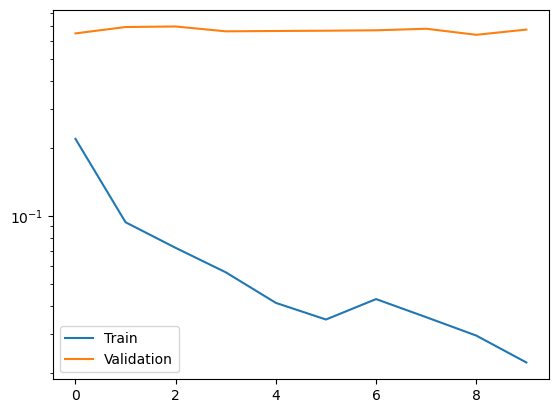

In [11]:
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.yscale("log")

In [26]:
y_preds = []
with torch.no_grad():
    for x, y in test_dataloader:
        y_pred = model(x)
        y_pred = y_pred.cpu().numpy().ravel()
        y_preds.append(y_pred)

y_preds = label_scaler.inverse_transform(np.vstack(y_preds))
y_true = test_dset.labels.cpu().numpy().ravel()

Text(0, 0.5, 'Prediction')

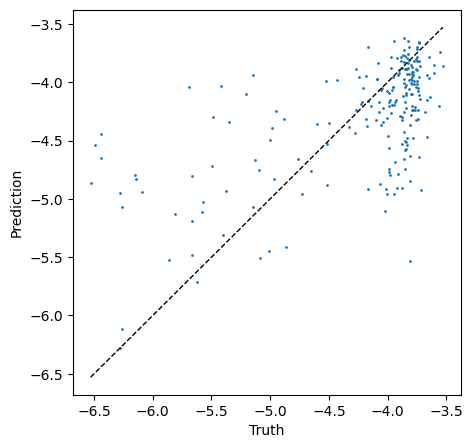

In [27]:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_preds, s=1)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "k--", lw=1)
plt.xlabel("Truth")
plt.ylabel("Prediction")